In [1]:
from utils.libraries import *
from utils.objects import *
from utils.functions import *

In [2]:
ml = MachineLearning()

ml.define_baseline_models()

{'LinearRegression': LinearRegression(),
 'PolynomialFeatures': PolynomialFeatures(),
 'DecisionTree': DecisionTreeRegressor(),
 'RandomForest': RandomForestRegressor(),
 'GradientBoosting': GradientBoostingRegressor(),
 'SVR': SVR(),
 'KNeighborsRegressor': KNeighborsRegressor()}

In [3]:
data = pd.read_csv(r'C:\Users\Joan Oliver\BullGlobe\Investing_Scripts\Economic_Market_Forecasting\src\data\processed\model_data_monthly.csv',index_col=0, header=0)

In [4]:
X_train, X_test, y_train, y_test = ml.split_data(test_size=0.3, data=data, target_col="SP500")
X_train_scaled, X_test_scaled = ml.scaler(X_train, X_test)

In [41]:
from sklearn.feature_selection import SelectKBest, f_classif
num_inds = X_train.shape[1]
# Select top-2 features
k = int(num_inds*.7)
selector = SelectKBest(score_func=f_classif, k=k)
X_new = selector.fit_transform(X_train, y_train)
selected_features = X_train.columns[selector.get_support()]
print(selected_features) 
data_corr = pd.DataFrame(data.corr()["SP500"].sort_values(ascending=False))
top_data_corr = data_corr[data_corr.index.isin(selected_features)]
print(top_data_corr)

Index(['10-Year Treasury Yield', '2-Year Treasury Yield',
       '5-Year Treasury Yield', '20-Year Treasury Yield',
       '30-Year Treasury Yield', '15-Year Mortgage Rate', 'Unemployment Rate',
       'PPI', 'Consumer Confidence Index', 'Government Debt',
       'Government Debt to GDP', 'US Dollar Index', 'Corporate Profits',
       'Building Permits', '3m10y', '2y20y', '5y10y', '10y30y',
       'Corporate_Bonds', 'Gold'],
      dtype='object')

In [9]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests

# Perform Granger Causality test
lag_order = 12  # Specify the maximum lag order
causality_matrix = np.zeros((len(X_train.columns), len(X_train.columns)))  # Empty matrix to store the causality results

for i, feature in enumerate(X_train.columns):
    for j, target in enumerate(X_train.columns):
        if i != j:
            # Perform the Granger Causality test
            test_result = grangercausalitytests(X_train[[target, feature]], maxlag=lag_order, verbose=False)
            p_value = test_result[lag_order][0]['ssr_ftest'][1]  # Get the p-value from the test result

            # Store the p-value in the causality matrix
            causality_matrix[i, j] = p_value

# Set a significance threshold
significance_threshold = 0.05

# Select features with significant causality
significant_features = X_train.columns[np.any(causality_matrix < significance_threshold, axis=0)]

# Subset the data with significant features
X_reduced = X_train[significant_features]

print(X_reduced.columns)
print(len(X_reduced.columns))


In [ ]:
ml.lag_generator()

In [14]:
def time_delay_embedding(series: pd.Series,
                         n_lags: int,
                         horizon: int,
                         return_Xy: bool = False):
    """
    Time delay embedding
    Time series for supervised learning
    :param series: time series as pd.Series
    :param n_lags: number of past values to used as explanatory variables
    :param horizon: how many values to forecast
    :param return_Xy: whether to return the lags split from future observations
    :return: pd.DataFrame with reconstructed time series
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    df_list = [series.shift(i) for i in n_lags_iter]
    df = pd.concat(df_list, axis=1).dropna()
    df.columns = [f'{name}(t-{j - 1})'
                  if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                  for j in n_lags_iter]

    df.columns = [re.sub('t-0', 't', x) for x in df.columns]

    if not return_Xy:
        return df

    is_future = df.columns.str.contains('\+')

    X = df.iloc[:, ~is_future]
    Y = df.iloc[:, is_future]
    if Y.shape[1] == 1:
        Y = Y.iloc[:, 0]

    return X, Y

In [15]:
import numpy as np
from scipy import stats
import statsmodels.tsa.stattools as ts


def covariance(x: np.ndarray, y: np.ndarray) -> float:
    """ Covariance between x and y
    """
    cov_xy = np.cov(x, y)[0][1]

    return cov_xy


def co_integration(x: np.ndarray, y: np.ndarray):
    """ Co-integration test between x and y
    """
    r, _, _ = ts.coint(x, y)

    return r


def correlation(x: np.ndarray,
                y: np.ndarray,
                method: str = "kendall"):
    """ Correlation between x and y
    """
    assert method in ["pearson", "spearman", "kendall"]

    corr, p_value = stats.pearsonr(x, y)

    return corr

In [16]:
data.drop("Government Debt to GDP", axis=1, inplace=True)

In [17]:
# from src.tde import time_delay_embedding

target_var = 'SP500'

colnames = data.columns.tolist()

# create data set with lagged features using time delay embedding
data_ds = []
for col in colnames:
    col_df = time_delay_embedding(data[col], n_lags=12, horizon=12)
    data_ds.append(col_df)

# concatenating all variables
data_df = pd.concat(data_ds, axis=1).dropna()

In [18]:
len(data_df.columns)

696

In [19]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor

# defining target (Y) and explanatory variables (X)
predictor_variables = data_df.columns.str.contains('\(t\-')
target_variables = data_df.columns.str.contains(f'{target_var}\(t\+')
X = data_df.iloc[:, predictor_variables]
Y = data_df.iloc[:, target_variables]

# train/test split
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X, Y, test_size=0.3, shuffle=False)

# fitting a lgbm model without feature engineering
model_wo_fe = MultiOutputRegressor(LGBMRegressor())
model_wo_fe.fit(X_tr, Y_tr)

# getting forecasts for the test set
preds_wo_fe = model_wo_fe.predict(X_ts)

# computing the MAPE error
mape(Y_ts, preds_wo_fe)
# 0.238

5.041796097288208

In [20]:
SUMMARY_STATS = {
    'mean': np.mean,
    'sdev': np.std,
}

univariate_features = {}
# for each column in the data
for col in colnames:
    # get lags for that column
    X_col = X.iloc[:, X.columns.str.startswith(col)]

    # for each summary stat
    for feat, func in SUMMARY_STATS.items():
        # compute that stat along the rows
        univariate_features[f'{col}_{feat}'] = X_col.apply(func, axis=1)

# concatenate features into a pd.DF
univariate_features_df = pd.concat(univariate_features, axis=1)

In [21]:
from scipy.spatial.distance import jensenshannon
from scipy import signal
from scipy.special import rel_entr

# from src.feature_extraction import covariance, co_integration

BIVARIATE_STATS = {
    'covariance': covariance,
    'co_integration': co_integration,
    'js_div': jensenshannon,
}

BIVARIATE_TRANSFORMATIONS = {
    'corr': signal.correlate,
    'conv': signal.convolve,
    'rel_entr': rel_entr,
}

# get all pairs of variables
col_combs = list(itertools.combinations(colnames, 2))

bivariate_features = []
# for each row
for i, _ in X.iterrows():
    # feature set in the i-th time-step
    feature_set_i = {}
    for col1, col2 in col_combs:
        # features for pair of columns col1, col2

        # getting the i-th instance for each column
        x1 = X.loc[i, X.columns.str.startswith(col1)]
        x2 = X.loc[i, X.columns.str.startswith(col2)]

        # compute each summary stat
        for feat, func in BIVARIATE_STATS.items():
            feature_set_i[f'{col1}|{col2}_{feat}'] = func(x1, x2)

        # for each transformation
        for trans_f, t_func in BIVARIATE_TRANSFORMATIONS.items():

            # apply transformation
            xt = t_func(x1, x2)

            # compute summary stat
            for feat, s_func in SUMMARY_STATS.items():
                feature_set_i[f'{col1}|{col2}_{trans_f}_{feat}'] = s_func(xt)

    bivariate_features.append(feature_set_i)

bivariate_features_df = pd.DataFrame(bivariate_features, index=X.index)

In [22]:
# concatenating all features with lags
X_with_features = pd.concat([X, univariate_features_df, bivariate_features_df], axis=1)

# train/test split
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X_with_features, Y, test_size=0.3, shuffle=False)

# fitting a lgbm model with feature engineering
model_w_fe = MultiOutputRegressor(LGBMRegressor())
model_w_fe.fit(X_tr, Y_tr)

# getting forecasts for the test set
preds_w_fe = model_w_fe.predict(X_ts)

# computing MAPE error
print(mape(Y_ts, preds_w_fe))
# 0.227

4.4883898265459665


In [23]:
# getting the importance of each feature in each horizon
avg_imp = pd.DataFrame([x.feature_importances_
                        for x in model_w_fe.estimators_]).mean()

# getting the top 100 features
n_top_features = 100

importance_scores = pd.Series(dict(zip(X_tr.columns, avg_imp)))
top_features = importance_scores.sort_values(ascending=False)[:n_top_features]
top_features_nm = top_features.index

# subsetting training and testing sets by those features
X_tr_top = X_tr[top_features_nm]
X_ts_top = X_ts[top_features_nm]

# re-fitting the lgbm model
model_top_features = MultiOutputRegressor(LGBMRegressor())
model_top_features.fit(X_tr_top, Y_tr)

# getting forecasts for the test set
preds_top_feats = model_top_features.predict(X_ts_top)

# computing MAE error
mape(Y_ts, preds_top_feats)
# 0.229
top_features = top_features.sort_values(ascending=False)
top_features = top_features[top_features.values > top_features.mean()]

7.746736377648532

<AxesSubplot:>

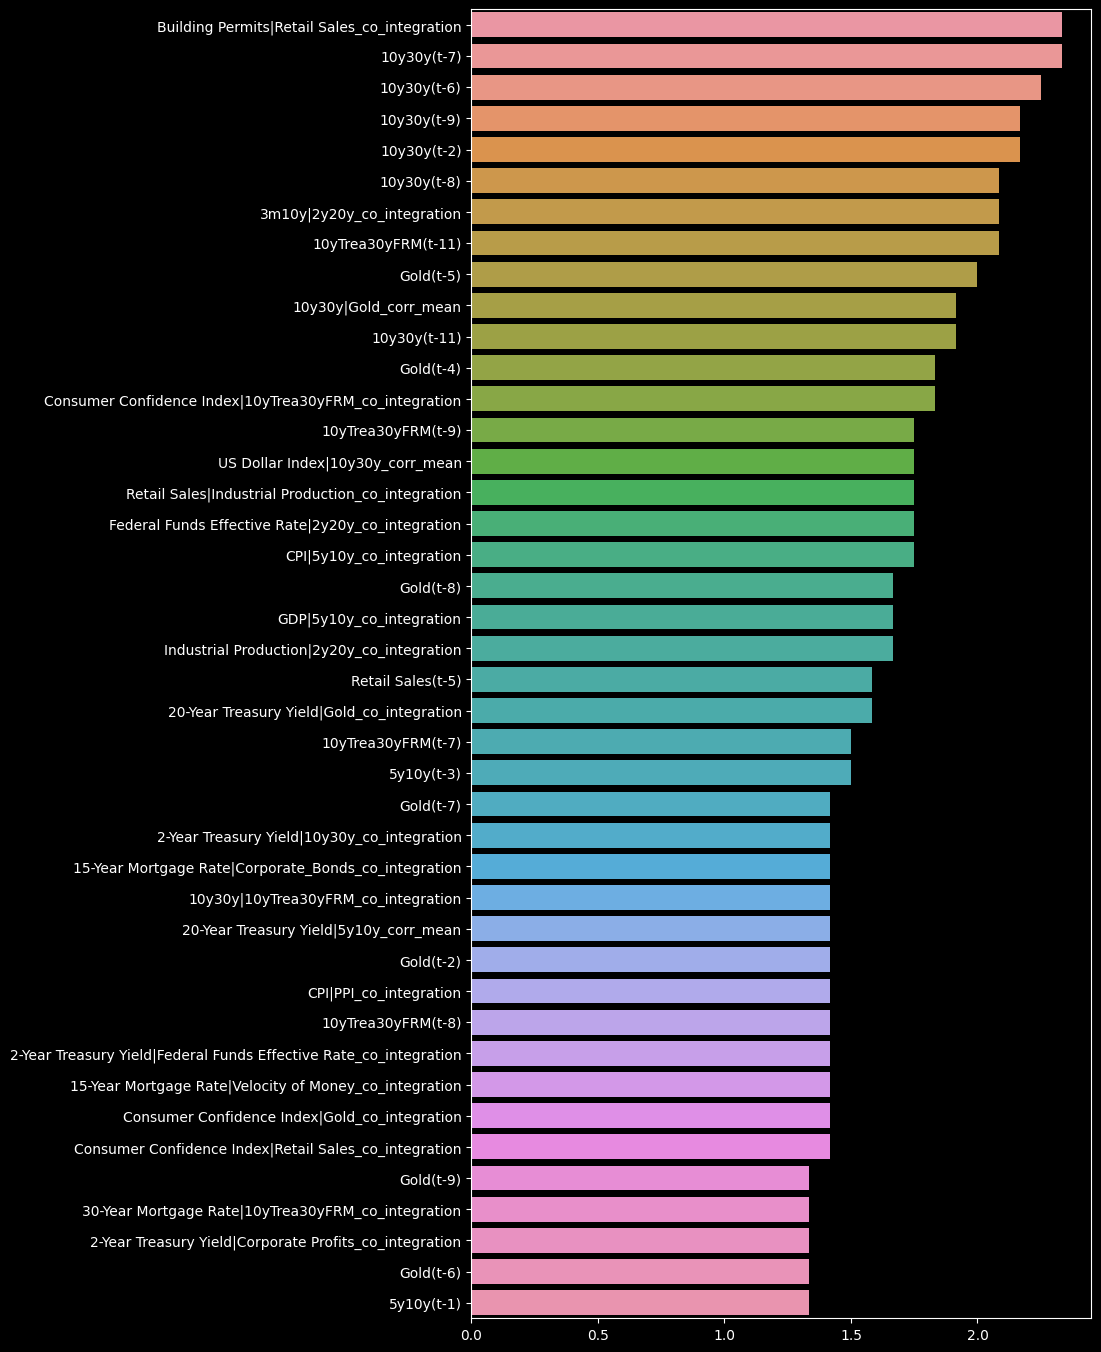

In [26]:
plt.figure(figsize=(8, 17))
sns.barplot(x=top_features.values, y=top_features.index)

In [ ]:
df_top_data[["Gold","SP500","MKT_GDP"]].cumsum().plot(figsize=(10, 6))

In [ ]:
df_lstm_history = pd.DataFrame({"Loss":lstm_model.history.history['loss'], "Val_Loss":lstm_model.history.history['val_loss']})

pred = lstm_model.predict(X_test_scale)
lstm_predictions = pd.DataFrame(pred, index=y_test.index)

df_lstm_history.plot(figsize=(10, 6))

lstm_model.save('models\moldes\lstm_best_model1.h5')
lstm_model.save_weights('lstm_best_weights.h5')
# lstm_model.summary()

plt.figure(figsize=(10, 6))
# plt.plot(df_all_lag_data["SP500"].pct_change())
plt.plot(y_test.index, y_test.cumsum(), label='Actual')
plt.plot((lstm_predictions).cumsum(), label="Pred")
plt.legend()


In [ ]:
df_all_data["SP500"].loc[:"2009-01-01"].plot(figsize=(10, 6))

In [ ]:
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(units=64, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mse')
    return model

def create_gru_model():
    model = Sequential()
    model.add(GRU(units=64, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mse')
    return model

def create_cnn_model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Flatten())
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
tf.random.set_seed(seed)

X = X_train_scale
y = y_train

lstm_model = KerasRegressor(build_fn=create_lstm_model())

In [ ]:
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
lstm_grid = GridSearchCV(estimator=lstm_model, param_grid=param_grid, n_jobs=-2, cv=3)
lstm_grid_result = lstm_grid.fit(X, y)

In [ ]:
print("Best: %f using %s" % (lstm_grid_result.best_score_, lstm_grid_result.best_params_))
means = lstm_grid_result.cv_results_['mean_test_score']
stds = lstm_grid_result.cv_results_['std_test_score']
params = lstm_grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], 1)))  # returns a sequence of vectors of dimension 32
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(64, return_sequences=True, activation='relu'))  # returns a sequence of vectors of dimension 32
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(32))  # return a single vector of dimension 32
lstm_model.add(Dense(1, activation='relu'))
lstm_model.compile(optimizer='adam', loss='mse')

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=64, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], 1)))  # returns a sequence of vectors of dimension 32
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(64, return_sequences=True))  # returns a sequence of vectors of dimension 32
lstm_model.add(LSTM(64))  # return a single vector of dimension 32
lstm_model.add(Dense(1, activation='relu'))

lstm_model.add(Dense(units=1))
lstm_model.compile(optimizer='adam', loss='mse')

### Defining the Pipelines

In [ ]:
X = df_top_data.drop(target, axis=1)
y = df_top_data[target]

steps = [
    ('scaling', StandardScaler()),
    ('split', 'passthrough')
]
# Step 2: Model Building and Grid Search
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(units=64, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mse')
    return model

def create_gru_model():
    model = Sequential()
    model.add(GRU(units=64, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mse')
    return model

def create_cnn_model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Flatten())
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=64, activation='relu', input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dense(units=1))
lstm_model.compile(optimizer='adam', loss='mse')

In [ ]:
from sklearn.feature_selection import SelectKBest
lstm = Pipeline([
    # ('scaler', StandardScaler()),
    # ('selectkbest',SelectKBest()),
    ('lstm_model', lstm_model)
])

gru = Pipeline([
    ('scaler', StandardScaler()),
    ('split', 'passthrough'),
    ('selectkbest',SelectKBest()),
    ('model', create_gru_model())
])

cnn = Pipeline([
    ('scaler', StandardScaler()),
    ('split', 'passthrough'),
    ('selectkbest',SelectKBest()),
    ('model', create_cnn_model())
])

In [ ]:
lstm.fit(X_train_scale, X_test_scale)

In [ ]:
# def create_varmax_model():
#     model = VARMAX(order=(1, 1))
#     return model

# Define the parameter grid for grid search
param_grid = {
    'epochs': [2, 4],
    'batch_size': [32, 64],
}
# param_grid_varmax = {
#     'epochs': [50, 100],
#     'batch_size': [32, 64],
#     'order': [(1, 1), (2, 1)]
# }

# Wrap the Keras models with KerasRegressor for compatibility with GridSearchCV
lstm_model = KerasRegressor(build_fn=create_lstm_model)
gru_model = KerasRegressor(build_fn=create_gru_model)
cnn_model = KerasRegressor(build_fn=create_cnn_model)
# varmax_model = KerasRegressor(build_fn=create_varmax_model)

# Perform grid search for each model
lstm_grid = GridSearchCV(estimator=lstm_model, param_grid=param_grid, scoring='neg_mean_squared_error')
gru_grid = GridSearchCV(estimator=gru_model, param_grid=param_grid, scoring='neg_mean_squared_error')
cnn_grid = GridSearchCV(estimator=cnn_model, param_grid=param_grid, scoring='neg_mean_squared_error')
# varmax_grid = GridSearchCV(estimator=varmax_model, param_grid=param_grid_varmax, scoring='mean_squared_error')

In [ ]:
# Define the steps for the pipeline
steps += [
    ('lstm_grid', lstm_grid),
    ('gru_grid', gru_grid),
    ('cnn_grid', cnn_grid),
    # ('varmax_grid',varmax_grid),
]
# Create the pipeline
pipeline = Pipeline(steps)

# Fit the pipeline to the data
pipeline.fit_transform(X_train, y_train)

In [ ]:
pipeline.best_estimator_

In [ ]:
# Get the best models from grid search
best_lstm_model = pipeline.named_steps['lstm_grid'].best_estimator_.model
best_gru_model = pipeline.named_steps['gru_grid'].best_estimator_.model
best_cnn_model = pipeline.named_steps['cnn_grid'].best_estimator_.model
# best_varmax_model = pipeline.named_steps['varmax_grid'].best_estimator_.model

In [ ]:
# Step 3: Model Training and Evaluation
# Train the best models
best_lstm_model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train, epochs=10)
best_gru_model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train, epochs=10)
best_cnn_model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train, epochs=10)
# best_varmax_model.fit(X_train, y_train)

In [ ]:
best_lstm_model.fit(X_train, y_train, epochs=20, validation_split=0.2,verbose=1)
best_gru_model.fit(X_train, y_train, epochs=20, validation_split=0.2,verbose=1)
best_cnn_model.fit(X_train, y_train, epochs=20, validation_split=0.2,verbose=1)

In [ ]:
best_lstm_model.save('best_lstm_model.h5')
best_lstm_model.save_weights('best_lstm_weights.h5')
best_lstm_model.summary()

In [ ]:
best_gru_model.save('best_gru_model.h5')
best_gru_model.save_weights('best_gru_weights.h5')
best_gru_model.summary()

In [ ]:
best_cnn_model.save('best_cnn_model.h5')
best_cnn_model.save_weights('best_cnn_weights.h5')
best_cnn_model.summary()

In [ ]:

# Step 4: Model Prediction and Visualization
# Predict using the best models
lstm_predictions = best_lstm_model.predict(X_test).flatten()
gru_predictions = best_gru_model.predict(X_test).flatten()
cnn_predictions = best_cnn_model.predict(X_test).flatten()
# cnn_predictions = best_cnn_model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))
# varmax_predictions = best_varmax_model.predict(X_test)

In [ ]:
gru_predictions = pd.DataFrame(gru_predictions, index=y_test.index)
gru_predictions = pd.DataFrame(gru_predictions, index=y_test.index)
gru_predictions = pd.DataFrame(gru_predictions, index=y_test.index)

In [ ]:
gru_predictions.describe()

In [ ]:
gru_predictions = gru_predictions[(gru_predictions > gru_predictions.quantile(0.05)) & (gru_predictions < gru_predictions.quantile(0.95))]

In [ ]:
gru_predictions.fillna(method='ffill', inplace=True)

In [ ]:
y_test

In [ ]:
df_all_lag_data_rets_no_outliers["SP500"].tail(100)

In [ ]:
gru_predictions.hist(bins=50)

In [ ]:
plt.figure(figsize=(10, 6))
# plt.plot(df_all_lag_data["SP500"].pct_change())
plt.plot(y_test.index, y_test.cumsum(), label='Actual')
plt.plot(((gru_predictions*100)-gru_predictions.mean()).cumsum(), label="Pred")
plt.legend()


In [ ]:
# Visualization

plt.figure(figsize=(10, 6))
# plt.plot(y_test.index, y_test.cumsum(), label='Actual')
plt.plot(y_test.index, lstm_predictions.cumsum(), label='LSTM')
# plt.plot(y_test.index, gru_predictions, label='GRU')
# plt.plot(y_test.index, cnn_predictions, label='CNN')
# plt.plot(y_test.index, varmax_predictions, label='VARMAX')
plt.xlabel('Date')
plt.ylabel('Target')
plt.title('Time Series Regression Deep Learning Models')
plt.legend()
plt.show()

In [ ]:
lstm_predictions.pct_change().cumsum().plot()

In [ ]:
((lstm_predictions * 10)-0.015).plot(
    figsize=(10, 6),
)

LSTM Testing

In [ ]:
data = df_top_lag_data.loc[:,df_top_lag_data.columns.isin(df_feature_importance.index)]
if "SP500(t)" in data.columns:
    pass
else:
    data = pd.concat([data, df_top_lag_data[["SP500(t)"]]], axis=1).dropna()

In [ ]:
cutoff_date = "2008-01-10"
# data = df_top_lag_data[df_top_lag_data.index<=cutoff_date]
data[data.index<=cutoff_date]
training_date = pd.to_datetime(data.index)
cols = list(data.columns)
df_for_training = data[cols].astype(float)
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training = scaler.transform(df_for_training)
trainX = []
trainY = []

n_future = 1
n_past = 14

for i in range(n_past, len(df_for_training) - n_future + 1):
    trainX.append(df_for_training[i - n_past:i, :df_for_training.shape[1]])
    trainY.append(df_for_training[i + n_future - 1:i + n_future, -1])

trainX, trainY = np.array(trainX), np.array(trainY)

print(trainX.shape)
print(trainY.shape)
# LSTM Model
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
layers = [
    keras.layers.LSTM(units=64, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])),
    # keras.layers.LSTM(units=64, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])),
    keras.layers.LSTM(units=16, activation='relu', return_sequences=False),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1, activation='relu')
]

model = Sequential(layers)
model.compile(optimizer="adam", loss="mse", )
model.summary()


In [ ]:
history = model.fit(trainX, trainY, epochs=15, batch_size=16, validation_split=0.1, verbose=1)
diff = pd.Series(history.history['val_loss']) - pd.Series(history.history['loss'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(diff)
plt.legend(['loss', 'val_loss', 'diff'])


In [ ]:
n = 66
forecast_period_dates = pd.date_range(list(training_date)[-1], periods=n, freq='W')
forecast = model.predict(trainX[-n:])
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]
pd.Series(y_pred_future).plot()
forecast_dates = []

for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())


In [ ]:
print(len(forecast_dates))
print(len(y_pred_future))

In [ ]:
data.columns

In [ ]:
df_forecast = pd.DataFrame({"SP500(t)":y_pred_future})
# df_forecast.index = pd.to_datetime(df_forecast.index).strftime("%Y-%m-%d")
# df_forecast.index[-1]
original = data[["SP500(t)"]].copy()
# plt.figure(figsize=(20,10))
df_final = pd.concat([original, df_forecast], axis=0)
df_final.cumsum().plot(figsize=(20,10))

In [ ]:

df_forecast = pd.DataFrame({"SP500":y_pred_future}, index=forecast_dates)
df_forecast.index = pd.to_datetime(df_forecast.index).strftime("%Y-%m-%d")
df_forecast.index[-1]
original = data[["SP500"]].copy()
original = original[original.index > "2005-01-01"]
# plt.figure(figsize=(20,10))
df_final = pd.concat([original, df_forecast], axis=0)
df_final.cumsum().plot(figsize=(20,10))

In [ ]:
df_all_data[["2y20y","10yTrea30yFRM", "Industrial Production", "CPI","SP500"]].cumsum().plot(figsize=(20,10))

In [ ]:
df_all_data.columns

In [ ]:
(df_all_data[["Industrial Production", "CPI"]].cumsum()).plot(figsize=(20,10))
df_all_data[["CPI"]].plot(figsize=(20,10))

In [1]:
from EMF_ML import *

EMF_ML(20,"W","SP500","2023-01-01")

> Load the market data config
> Load the economic data config
> Setting up the indicator dictionaries
> Extracting the indicator data
   -->Extracting 10-Year Treasury Yield...
   -->Extracting 2-Year Treasury Yield...
   -->Extracting Federal Funds Effective Rate...
   -->Extracting 1-Month Treasury Yield...
   -->Extracting 3-Month Treasury Yield...
   -->Extracting 5-Year Treasury Yield...
   -->Extracting 20-Year Treasury Yield...
   -->Extracting 30-Year Treasury Yield...
   -->Extracting 15-Year Mortgage Rate...
   -->Extracting 30-Year Mortgage Rate...
   -->Extracting Unemployment Rate...
   -->Extracting GDP...
   -->Extracting Real GDP...
   -->Extracting CPI...
   -->Extracting PPI...
   -->Extracting Consumer Confidence Index...
   -->Extracting Government Debt...
   -->Extracting Debt Service vs Disposable Income...
   -->Extracting US Dollar Index...
   -->Extracting Corporate Profits...
   -->Extracting EBIT...
   -->Extracting Retained Earnings...
   -->Extracting Build

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').